In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import warnings
import os
import shutil

# Filtering warnings
warnings.simplefilter('ignore')

# Giving random seed
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
print("GPU Active: ", len(tf.config.list_physical_devices('GPU')))

GPU Active:  1


In [2]:
# Main & target directories
source_folder = '/kaggle/input/isic-2020-jpg-256x256-resized/train-image/image'  # Source dir
train_folder = '/kaggle/working/train'  # Train dir
test_folder = '/kaggle/working/test'  # Test dir

# Creating folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get images
image_files = [f for f in os.listdir(source_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Determining labels for split images by classes
labels = ['benign', 'malignant']  # Class labels

# Creating folders and splitting
for label in labels:
    os.makedirs(os.path.join(train_folder, label), exist_ok=True)
    os.makedirs(os.path.join(test_folder, label), exist_ok=True)

# Splitting images with labels
all_images = []

for image in image_files:
    # Labeling classes
    if 'benign' in image:
        label = 'benign'
    else:
        label = 'malignant'
    
    all_images.append((image, label))

# Splitting train and test data
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Transfering process of train and test sets 
for image, label in train_images:
    shutil.copy(os.path.join(source_folder, image), os.path.join(train_folder, label, image))

for image, label in test_images:
    shutil.copy(os.path.join(source_folder, image), os.path.join(test_folder, label, image))

print("Images succesfully classified and transfered.")

Images succesfully classified and transfered.


In [3]:
# Creating a function for add Gaussian Noise
def add_noise(image, mean=0, sigma=10):
    gaussian_noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.array(image, dtype=np.float32) + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)  # Hold the image between 0-255
    return noisy_image

# Data Augmentation (with noise)
def custom_data_generator(datagen, directory, batch_size=32, target_size=(224, 224)):
    # While uploading datas we can use custom augmentations
    for batch in datagen.flow_from_directory(directory,
                                             batch_size=batch_size,
                                             target_size=target_size,
                                             shuffle=True):
        images, labels = batch
        
        augmented_images = []
        for image in images:
            image = np.array(image * 255, dtype=np.uint8)  # Transforming image between 0-255

            # Adding noise to the image
            noisy_image = add_noise(image, mean=0, sigma=10)  # Adding low noise

            augmented_images.append(noisy_image)
        
        augmented_images = np.array(augmented_images) / 255.0  # Normalization
        yield augmented_images, labels


In [4]:
# ImageDataGenerator for train data
train_datagen = ImageDataGenerator(rescale=1./255, # Data normalization
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True)

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Train & Test sets
train_set = custom_data_generator(train_datagen,
                                  train_folder,
                                  batch_size=32,
                                  target_size=(224, 224))

test_set = test_datagen.flow_from_directory(test_folder,
                                            shuffle = False,
                                            target_size=(224, 224), 
                                            batch_size=32,
                                            class_mode='categorical')

Found 6626 images belonging to 2 classes.


In [18]:
# ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing weights (stopping fine-tunning on first step)
base_model.trainable = False

for layer in base_model.layers[-10:]:  # Son 10 katmanı serbest bırak
    layer.trainable = True

# GlobalAveragePooling2D for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Dense & Dense layers for stop overfitting
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer (binary classification)
predictions = Dense(2, activation='softmax')(x)

In [19]:
# Completing model
model = Model(inputs=base_model.input, outputs=predictions)

# Compiling model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

for layer in base_model.layers[-10:]: # last 10 layers free (fine-tuning)
    layer.trainable = True

# Creating folder to save the model
model_dir = "/kaggle/working/models"
os.makedirs(model_dir, exist_ok=True)

# Model folder path
best_model_file = os.path.join(model_dir, "isic2020-model.keras")

callbacks = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1) ]

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,155,330 (92.15 MB)

 Trainable params: 5,032,386 (19.20 MB)

 Non-trainable params: 19,122,944 (72.95 MB)

In [20]:
# Numbers of samples
num_train_samples = sum(len(files) for _, _, files in os.walk(train_folder))
num_test_samples = sum(len(files) for _, _, files in os.walk(test_folder))
print(f"Total train sample number: {num_train_samples}")
print(f"Total test sample number: {num_test_samples}")

Total train sample number: 26500
Total test sample number: 6626


(32, 224, 224, 3) (32, 2)


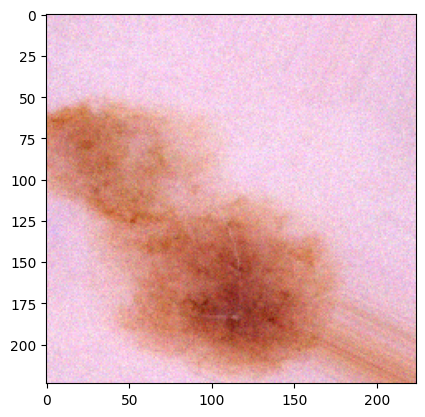

Label:  [0. 1.]


In [21]:
# Image and label sample
for img, label in train_set:
    print(img.shape, label.shape)
    plt.imshow(img[0])
    plt.show()
    print("Label: ", label[0])
    break

In [22]:
# Training step
r = model.fit(
    train_set,
    validation_data=test_set,
    epochs= 50,
    steps_per_epoch= num_train_samples // 32,
    validation_steps= num_test_samples // 32,
    callbacks=callbacks)

Epoch 1/50
828/828 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5722 - loss: 0.8211
Epoch 1: val_loss improved from inf to 0.38399, saving model to /kaggle/working/models/isic2020-model.keras
828/828 ━━━━━━━━━━━━━━━━━━━━ 464s 544ms/step - accuracy: 0.5724 - loss: 0.8209 - val_accuracy: 1.0000 - val_loss: 0.3840 - learning_rate: 1.0000e-04
Epoch 2/50
828/828 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9059 - loss: 0.3499
Epoch 2: val_loss improved from 0.38399 to 0.19355, saving model to /kaggle/working/models/isic2020-model.keras
828/828 ━━━━━━━━━━━━━━━━━━━━ 433s 524ms/step - accuracy: 0.9059 - loss: 0.3498 - val_accuracy: 1.0000 - val_loss: 0.1936 - learning_rate: 1.0000e-04
Epoch 3/50
828/828 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9882 - loss: 0.1381
Epoch 3: val_loss improved from 0.19355 to 0.05547, saving model to /kaggle/working/models/isic2020-model.keras
828/828 ━━━━━━━━━━━━━━━━━━━━ 442s 535ms/step - accuracy: 0.9882 - loss: 0.1381 - val_accuracy: 1.0000 - va

In [23]:
# Best validation accuracy value
best_val_acc = max(r.history['val_accuracy'])
print(f'Best validation Accuracy : {best_val_acc}')

Best validation Accuracy : 1.0


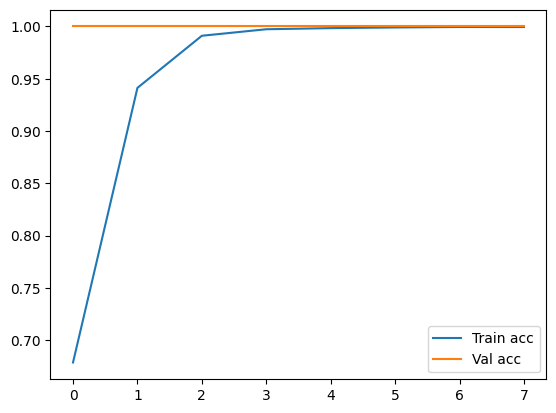

In [24]:
# Train accuracy & validation accuracy graphic
plt.plot(r.history['accuracy'], label='Train acc')
plt.plot(r.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

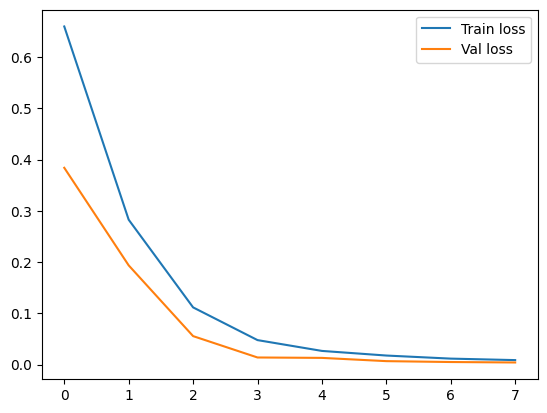

In [25]:
# Train loss & validation loss graphic
plt.plot(r.history['loss'], label='Train loss')
plt.plot(r.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, auc

# Get test classes
y_true = test_set.classes  

# Get model predictions
y_pred_probs = model.predict(test_set, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)  # Making dimensional if one-hot encoded

# Get class names from test set
target_names = list(test_set.class_indices.keys())  

# Classification report (with labels)
report = classification_report(y_true, y_pred, target_names=target_names, labels=[0, 1], output_dict=True)

# Accuracy calculation (sklearn)
accuracy = accuracy_score(y_true, y_pred)

# AUC calculation (if just 2 class)
if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_pred_probs[:, 1])  
else:
    auc = 'Not Applicable (Only one class in y_true)'

# Recall and F1-score
recall = report[target_names[1]]['recall']  
f1_score = report[target_names[1]]['f1-score']  

# Printing results
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'AUC: {auc}')


208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step
Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: Not Applicable (Only one class in y_true)


In [28]:
import numpy as np
print(np.unique(y_true, return_counts=True))

(array([1], dtype=int32), array([6626]))


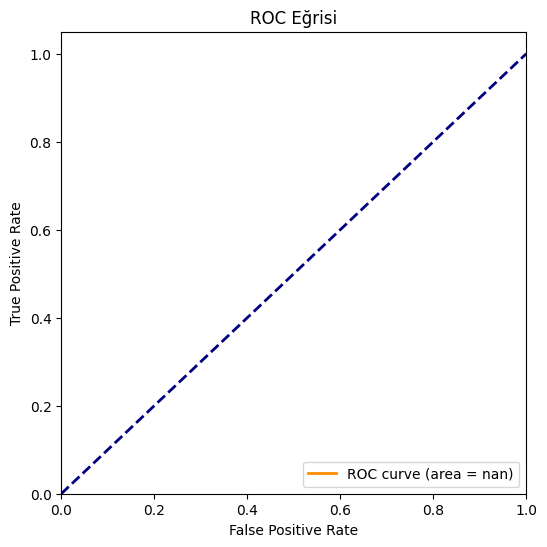

In [27]:
from sklearn.metrics import roc_curve, auc

# Calculating ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc_value = auc(fpr, tpr)  # AUC function

# ROC & AUC graphic
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.show()